# Кластеризация данных слушаний Москвы

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

# EDA

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
geo_comment_raw = pd.read_excel('geo_comment.xlsx')
geo_raw = pd.read_excel('geo.xlsx')

In [3]:
geo_comment_raw.head()

,x,y,comment_class,multiplier,comment
0,37.612416,55.777454,-1,1,Во все разделы правил землепользования и застр...
1,37.612416,55.777454,-1,1,На основании вступившего в законную силу судеб...
2,37.603298,55.742108,-1,1,Внести в Проект правил землепользования и заст...
3,37.558526,55.728758,-1,1,Учитывая социальную значимость проекта строите...
4,37.566431,55.731794,-1,1,Учитывая социальную значимость проекта строите...


In [4]:
geo_comment_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70382 entries, 0 to 70381
Data columns (total 5 columns):
x                70382 non-null float64
y                70382 non-null float64
comment_class    70382 non-null int64
multiplier       70382 non-null int64
comment          70382 non-null object
dtypes: float64(2), int64(2), object(1)
memory usage: 3.2+ MB


In [5]:
geo_raw.head()

,x,y,comment_class
0,37.612416,55.777454,-1
1,37.612416,55.777454,-1
2,37.603298,55.742108,-1
3,37.558526,55.728758,-1
4,37.566431,55.731794,-1


In [6]:
geo_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108806 entries, 0 to 108805
Data columns (total 3 columns):
x                108806 non-null float64
y                108806 non-null float64
comment_class    108806 non-null int64
dtypes: float64(2), int64(1)
memory usage: 3.3 MB


In [7]:
geo_comment_raw.multiplier.sum() == len(geo_raw)

True

In [8]:
geo_raw.comment_class.value_counts(dropna=False)

-1    95147
 1    13659
Name: comment_class, dtype: int64

In [9]:
geo_comment_raw.columns = ['longitude', 'latitude', 'comment_class', 'multiplier', 'comment']
geo_comment_raw.head(2)

,longitude,latitude,comment_class,multiplier,comment
0,37.612416,55.777454,-1,1,Во все разделы правил землепользования и застр...
1,37.612416,55.777454,-1,1,На основании вступившего в законную силу судеб...


In [10]:
geo_raw.columns = ['longitude', 'latitude', 'comment_class']
geo_raw.head(2)

,longitude,latitude,comment_class
0,37.612416,55.777454,-1
1,37.612416,55.777454,-1


## Intial Drawings

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline

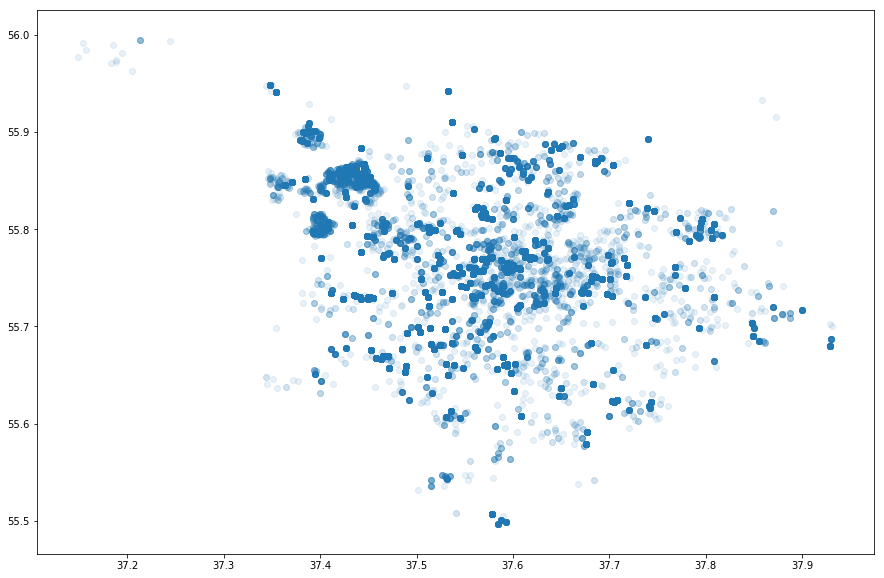

In [12]:
plt.figure(figsize=(15,10))
plt.scatter(geo_raw.longitude,geo_raw.latitude,alpha=0.1)

In [13]:
from gmplot import gmplot
gmap = gmplot.GoogleMapPlotter(geo_raw.latitude.mean(), geo_raw.longitude.mean(), 9)
gmap.heatmap(geo_raw.latitude,geo_raw.longitude)
gmap.draw("my_map.html")

![title](SIMPLE_HEATMAP.png)

# Common code

In [14]:
#support code to define convex hull for set of points
def split(u, v, points):
    # return points on left side of UV
    return [p for p in points if np.cross(p - u, v - u) < 0]

def extend(u, v, points):
    if not points:
        return []

    # find furthest point W, and split search to WV, UW
    w = min(points, key=lambda p: np.cross(p - u, v - u))
    p1, p2 = split(w, v, points), split(u, w, points)
    return extend(w, v, p1) + [w] + extend(u, w, p2)

def convex_hull(points):
    # find two hull points, U, V, and split to left and right search
    u = min(points, key=lambda p: p[0])
    v = max(points, key=lambda p: p[0])
    left, right = split(u, v, points), split(v, u, points)

    # find convex hull on each side
    points = []
    for each in [v] + extend(u, v, left) + [u] + extend(v, u, right) + [v]:
        points.append(list(each))
    return np.array(points)

In [15]:
#generate random hex color
import random
def rand_color_hex():
    return '#%02X%02X%02X' % (random.randint(0,255),random.randint(0,255),random.randint(0,255))

In [16]:
from gmplot import gmplot
def draw_cluster_random_color(geo_data,pred_series,restrict=[]):
    color_map = [rand_color_hex() for _ in range(0,pred_series.max()+1)]
    # Place map
    gmap = gmplot.GoogleMapPlotter(geo_raw.latitude.mean(), geo_raw.longitude.mean(), 9)
    for each in range(0,pred_series.max()+1):
        if (len(restrict)==0) or (each in restrict):
            points = convex_hull(np.array(geo_data[pred_series==each]))
            gmap.plot(points[:,0], points[:,1], color_map[each], edge_width=10)
    gmap.draw("my_map.html")

# DBSCAN clustering

## All classes

In [17]:
X = geo_raw[['latitude','longitude']]

In [18]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(X)
X_all = ss.transform(X)

In [19]:
from sklearn.cluster import DBSCAN
dbs = DBSCAN(n_jobs=1,eps=0.1, min_samples=len(X_all)/1000) #eps selected to make number of cluster reasonable
predictions = dbs.fit_predict(X_all)

In [20]:
#count number of clusters with DBSCAN
print(f"Number of clusters {predictions.max()}")

pred_series = pd.Series(predictions)

Number of clusters 54


In [21]:
draw_cluster_random_color(X,pred_series)

![title](DBSCAN_IGNORE_CLASS.png)

## Only negatives

In [22]:
X_neg = geo_raw[['latitude','longitude']][geo_raw.comment_class==-1].reset_index().drop('index',axis=1)

In [23]:
ss_neg = StandardScaler()
ss_neg.fit(X_neg)
X_neg_scaled = ss_neg.transform(X_neg)

In [24]:
dbc_neg = DBSCAN(n_jobs=1,eps=0.1,min_samples=len(X_neg_scaled)/1000)
prediction_neg = dbc_neg.fit_predict(X_neg_scaled)

In [25]:
#count number of clusters with DBSCAN
print(f"Number of clusters {prediction_neg.max()}")

pred_neg_series = pd.Series(prediction_neg)

Number of clusters 54


In [26]:
draw_cluster_random_color(X_neg[['latitude','longitude']],pred_neg_series)

![title](DBSCAN_ONLY_NEG.png)

## Only positive

In [27]:
X_pos = geo_raw[['latitude','longitude']][geo_raw.comment_class==1].reset_index().drop('index',axis=1)

In [28]:
ss_pos = StandardScaler()
ss_pos.fit(X_pos)
X_pos_scaled = ss_pos.transform(X_pos)

In [29]:
dbc_pos = DBSCAN(n_jobs=1,eps=0.1,min_samples=len(X_pos_scaled)/1000)
prediction_pos = dbc_pos.fit_predict(X_pos_scaled)

In [30]:
#count number of clusters with DBSCAN
print(f"Number of clusters {prediction_pos.max()}")

pred_pos_series = pd.Series(prediction_pos)

Number of clusters 37


In [31]:
draw_cluster_random_color(X_pos[['latitude','longitude']],pred_pos_series)

![title](DBSCAN_ONLY_POSITIVE.png)

# KMEANS clustering

In [32]:
X_km = geo_raw[['latitude','longitude']]

In [33]:
ss_km = StandardScaler()
ss_km.fit(X_km)
X_all_km = ss_km.transform(X_km)

In [34]:
from sklearn.cluster import KMeans

In [35]:
k_inertia = []
ks = range(1,30)

for k in ks:
    km = KMeans(n_clusters=k, random_state=42)
    clusters_kmeans = km.fit_predict(X_all_km, )
    k_inertia.append(km.inertia_)
diff = np.diff(k_inertia)
diff_r = diff[1:] / diff[:-1]
k_opt = ks[np.argmin(diff_r)+1]
k_opt

15

In [36]:
km = KMeans(n_clusters=k_opt, random_state=42)
predictions_km = km.fit_predict(X_all_km)

In [37]:
pred_km_series = pd.Series(predictions_km)

In [38]:
draw_cluster_random_color(X_km,pred_km_series)

![title](KMEANS_15.png)

## [EXTRA] Find top denisity voting districts

## Top voters by count

In [39]:
topn = 5
top_voters = pred_series[pred_series!=-1].value_counts(normalize=True).head(topn).index
top_voters_predictions = pred_series[pred_series.isin(top_voters)]

In [40]:
X_all_top = X[pred_series.isin(top_voters_predictions)]

In [41]:
draw_cluster_random_color(X_all_top,top_voters_predictions,top_voters)

![title](TOP5_VOTERS.png)

## Top voters by density

In [42]:
#support function to get area of polygon on Earth's surface
def reproject(latitude, longitude):
    """Returns the x & y coordinates in meters using a sinusoidal projection"""
    from math import pi, cos, radians
    earth_radius = 6371009 # in meters
    lat_dist = pi * earth_radius / 180.0

    y = [lat * lat_dist for lat in latitude]
    x = [long * lat_dist * cos(radians(lat)) 
                for lat, long in zip(latitude, longitude)]
    return x, y
def area_of_polygon(x, y):
    """Calculates the area of an arbitrary polygon given its verticies"""
    area = 0.0
    for i in range(-1, len(x)-1):
        area += x[i] * (y[i+1] - y[i-1])
    return abs(area) / 2.0

from shapely.geometry import Polygon

In [43]:
densities = {}
some_house_area = 100*20 + 90*20 #https://yandex.ru/maps/213/moscow/?ll=37.569489%2C55.782327&z=17.5
for each in range(0,pred_series.max()+1):
    points = convex_hull(np.array(X[pred_series==each]))
    rprj = reproject(points[:,0],points[:,1])
    #some areas are very small, substitue it with one house area
    area = max(Polygon(list(zip(rprj[0], rprj[1]))).area,some_house_area)     
    population = len(pred_series[pred_series==each])
    #normalize a bit
    density = 1000 * population/area
    densities[each] = density

In [44]:
top_voters_dens = sorted(densities,key=lambda x: densities[x], reverse=True)[:5]
top_voters_predictions_dens = pred_series[pred_series.isin(top_voters_dens)]
X_all_top_dens = X[pred_series.isin(top_voters_predictions_dens)]

In [45]:
draw_cluster_random_color(X_all_top_dens,top_voters_predictions_dens,top_voters_dens)

![title](DBSCAN_TOP5_DENSE.png)

### Conclusion:
With DBSCAN very small but dense regions are treated as separate clusters, which is not very representitve from densivity analysis point of view. At the same time it highlight five very active local communities in big city.

## Top voters by density KMEANS

In [46]:
densities = {}
some_house_area = 100*20 + 90*20 #https://yandex.ru/maps/213/moscow/?ll=37.569489%2C55.782327&z=17.5
for each in range(0,pred_km_series.max()+1):
    points = convex_hull(np.array(X[pred_km_series==each]))
    rprj = reproject(points[:,0],points[:,1])
    #some areas are very small, substitue it with one house area
    area = max(Polygon(list(zip(rprj[0], rprj[1]))).area,some_house_area)     
    population = len(pred_km_series[pred_km_series==each])
    #normalize a bit
    density = 1000 * population/area
    densities[each] = density

In [47]:
top_voters_dens_km = sorted(densities,key=lambda x: densities[x], reverse=True)[:5]
top_voters_predictions_dens_km = pred_km_series[pred_km_series.isin(top_voters_dens_km)]
X_all_top_dens_km = X[pred_km_series.isin(top_voters_predictions_dens_km)]

In [48]:
draw_cluster_random_color(X_all_top_dens_km,top_voters_predictions_dens_km,top_voters_dens_km)

![title](KMEANS_TOP5_DENSE.png)


### Conclusion:
With KMEANS regions are bigger and any data point is associated with come cluster, so they result much bigger.Such analysis show bigger picture and, at least visually, match quite well to heat map.